In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import  cross_val_score
from xgboost import XGBRegressor
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df=pd.read_csv('d:/kaggle/Titanic/train.csv')
test_df=pd.read_csv('d:/kaggle/Titanic/test.csv')

In [3]:
train_df['train_test'] = 1
test_df['train_test'] = 0
test_df['Survived'] = np.NaN
all_data = pd.concat([train_df,test_df])
%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

In [4]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [5]:
all_data['Title'] = all_data['Name'].apply(get_title)
all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')

In [6]:
all_data['Title'] = all_data['Title'].replace(
       ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 
       'Rare')

In [7]:
all_data.Age = all_data.Age.fillna(train_df.Age.median())
#all_data.Fare = all_data.Fare.fillna(training.Fare.mean())
all_data.Fare = all_data.Fare.fillna(train_df.Fare.median())

In [8]:
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)

In [9]:
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])

In [10]:
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,Title,numeric_ticket,cabin_multiple,cabin_adv
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr,0,0,n
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs,0,1,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss,0,0,n
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs,1,1,C
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Mr,1,0,n


In [11]:
data=all_data.copy()

In [12]:
data.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [13]:
data['Embarked'] = data['Embarked'].replace('S', 1)
data['Embarked'] = data['Embarked'].replace('C', 2)
data['Embarked'] = data['Embarked'].replace('Q', 3)

In [14]:
data.cabin_adv.value_counts()

n    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: cabin_adv, dtype: int64

In [15]:
data['cabin_adv'] = data['cabin_adv'].replace('n', 1)
data['cabin_adv'] = data['cabin_adv'].replace('C', 2)
data['cabin_adv'] = data['cabin_adv'].replace('B', 3)
data['cabin_adv'] = data['cabin_adv'].replace('D', 4)
data['cabin_adv'] = data['cabin_adv'].replace('E', 5)
data['cabin_adv'] = data['cabin_adv'].replace('A', 6)
data['cabin_adv'] = data['cabin_adv'].replace('F', 7)
data['cabin_adv'] = data['cabin_adv'].replace('G', 8)
data['cabin_adv'] = data['cabin_adv'].replace('T', 9)

In [16]:
data['Sex'] = data['Sex'].replace('male', 1)
data['Sex'] = data['Sex'].replace('female', 2)

In [17]:
data.Title.value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: Title, dtype: int64

In [18]:
data['Title'] = data['Title'].replace('Mr', 1)
data['Title'] = data['Title'].replace('Miss', 2)
data['Title'] = data['Title'].replace('Mrs', 3)
data['Title'] = data['Title'].replace('Master', 4)
data['Title'] = data['Title'].replace('Rare', 5)

In [19]:
data=data.drop(['Name','Ticket','Title','Cabin'], axis =1)

In [20]:
data.isna().sum().sort_values(ascending=False)

Survived          418
Embarked            2
PassengerId         0
Pclass              0
Sex                 0
Age                 0
SibSp               0
Parch               0
Fare                0
train_test          0
numeric_ticket      0
cabin_multiple      0
cabin_adv           0
dtype: int64

In [21]:
data.Embarked.value_counts()

1.0    914
2.0    270
3.0    123
Name: Embarked, dtype: int64

In [22]:
data.Embarked = data.Embarked.fillna(train_df.Fare.median())

In [23]:
data.isna().sum().sort_values(ascending=False)

Survived          418
PassengerId         0
Pclass              0
Sex                 0
Age                 0
SibSp               0
Parch               0
Fare                0
Embarked            0
train_test          0
numeric_ticket      0
cabin_multiple      0
cabin_adv           0
dtype: int64

In [24]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = data.copy()

In [25]:
all_dummies_scaled 

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,train_test,numeric_ticket,cabin_multiple,cabin_adv
0,1,0.0,3,1,22.0,1,0,7.2500,1.0,1,0,0,1
1,2,1.0,1,2,38.0,1,0,71.2833,2.0,1,0,1,2
2,3,1.0,3,2,26.0,0,0,7.9250,1.0,1,0,0,1
3,4,1.0,1,2,35.0,1,0,53.1000,1.0,1,1,1,2
4,5,0.0,3,1,35.0,0,0,8.0500,1.0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,1,28.0,0,0,8.0500,1.0,0,0,0,1
414,1306,NaN,1,2,39.0,0,0,108.9000,2.0,0,0,1,2
415,1307,NaN,3,1,38.5,0,0,7.2500,1.0,0,0,0,1
416,1308,NaN,3,1,28.0,0,0,8.0500,1.0,0,1,0,1


In [26]:
all_dummies_scaled[['Pclass','Sex','SibSp','Embarked','Parch','Age','Fare','cabin_adv']]= scale.fit_transform(all_dummies_scaled[['Pclass','Sex','SibSp','Embarked','Parch','Age','Fare','cabin_adv']])
all_dummies_scaled

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,train_test,numeric_ticket,cabin_multiple,cabin_adv
0,1,0.0,0.841916,-0.743497,-0.581628,0.481288,-0.445000,-0.503291,-0.500508,1,0,0,-0.441136
1,2,1.0,-1.546098,1.344995,0.658652,0.481288,-0.445000,0.734744,0.706261,1,0,1,0.276189
2,3,1.0,0.841916,1.344995,-0.271558,-0.479087,-0.445000,-0.490240,-0.500508,1,0,0,-0.441136
3,4,1.0,-1.546098,1.344995,0.426099,0.481288,-0.445000,0.383183,-0.500508,1,1,1,0.276189
4,5,0.0,0.841916,-0.743497,0.426099,-0.479087,-0.445000,-0.487824,-0.500508,1,1,0,-0.441136
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,0.841916,-0.743497,-0.116523,-0.479087,-0.445000,-0.487824,-0.500508,0,0,0,-0.441136
414,1306,NaN,-1.546098,1.344995,0.736169,-0.479087,-0.445000,1.462034,0.706261,0,0,1,0.276189
415,1307,NaN,0.841916,-0.743497,0.697411,-0.479087,-0.445000,-0.503291,-0.500508,0,0,0,-0.441136
416,1308,NaN,0.841916,-0.743497,-0.116523,-0.479087,-0.445000,-0.487824,-0.500508,0,1,0,-0.441136


In [27]:
all_dummies_scaled=all_dummies_scaled.drop(['PassengerId','Survived'], axis =1)

In [28]:
#all_dummies_scaled=all_dummies_scaled.drop(['Embarked'], axis =1)

In [29]:
X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

In [30]:
X_train_scaled.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,numeric_ticket,cabin_multiple,cabin_adv
0,0.841916,-0.743497,-0.581628,0.481288,-0.445,-0.503291,-0.500508,0,0,-0.441136
1,-1.546098,1.344995,0.658652,0.481288,-0.445,0.734744,0.706261,0,1,0.276189
2,0.841916,1.344995,-0.271558,-0.479087,-0.445,-0.490240,-0.500508,0,0,-0.441136
3,-1.546098,1.344995,0.426099,0.481288,-0.445,0.383183,-0.500508,1,1,0.276189
4,0.841916,-0.743497,0.426099,-0.479087,-0.445,-0.487824,-0.500508,1,0,-0.441136


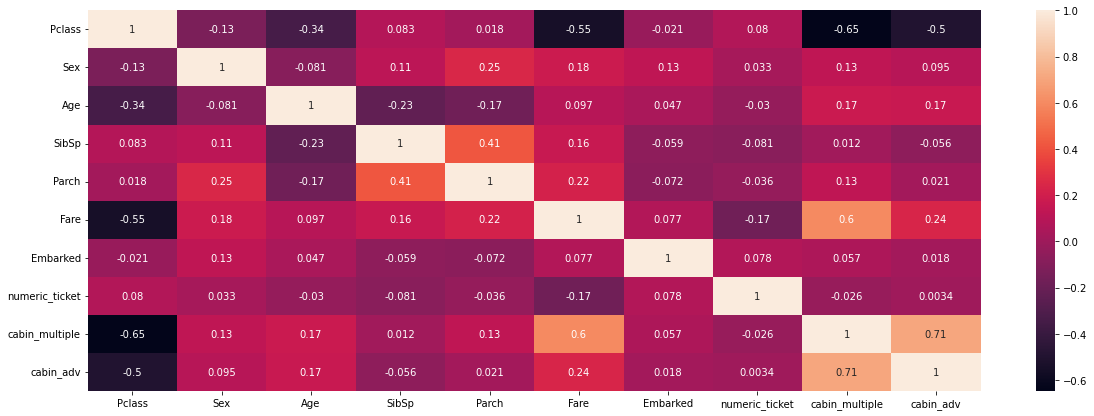

In [31]:
numeric_corr = X_train_scaled.corr()
plt.figure(figsize = (20,7))
sns.heatmap(numeric_corr, annot = True);

In [32]:
X_train_scaled.isna().sum().sort_values(ascending=False)

Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
Embarked          0
numeric_ticket    0
cabin_multiple    0
cabin_adv         0
dtype: int64

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [35]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.81005587 0.79213483 0.79213483 0.76966292 0.8258427 ]
0.7979662293641328


In [37]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.78212291 0.76404494 0.82022472 0.78651685 0.82022472]
0.7946268281965978


In [38]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.7877095  0.78089888 0.85955056 0.75842697 0.83707865]
0.8047329106772958


In [39]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.83240223 0.80898876 0.82022472 0.80337079 0.84831461]
0.8226602222082733


In [40]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.76536313 0.82022472 0.86516854 0.78651685 0.84831461]
0.8171175695185487


In [45]:
from sklearn.neural_network import MLPClassifier
MLP=MLPClassifier(max_iter=3000)
cv = cross_val_score(MLP,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.7877095  0.78651685 0.82022472 0.78651685 0.79775281]
0.795744146632352


In [54]:
DCT= tree.DecisionTreeClassifier(random_state=10)
cv = cross_val_score(DCT,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.73184358 0.7752809  0.8258427  0.75842697 0.84269663]
0.7868181532860461


In [41]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 

In [42]:
cv = cross_val_score(voting_clf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.7877095  0.81460674 0.85393258 0.79775281 0.84269663]
0.8193396522503296


In [75]:
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('mlp',MLP),('svc',svc),('xgb',xgb)], voting = 'soft') 

In [76]:
cv = cross_val_score(voting_clf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.79888268 0.82022472 0.85955056 0.79213483 0.85393258]
0.8249450756386919


In [77]:
voting_clf.fit(X_train_scaled,y_train)
y_hat_base_vc = voting_clf.predict(X_test_scaled).astype(int)
basic_submission = {'PassengerId': test_df.PassengerId, 'Survived': y_hat_base_vc}
base_submission = pd.DataFrame(data=basic_submission)
base_submission.to_csv('submission.csv', index=False)